In [ ]:
import keras
keras.__version__

'2.4.3'

In [ ]:
# 데이터 로드
#from keras.datasets import mnist
#from keras.datasets import fashion_mnist
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [ ]:
train_images.shape # 이미지 장수, 행, 열, 채널 / 채널이 없다면 흑백이미지

(50000, 32, 32, 3)

In [ ]:
len(train_labels)

50000

In [ ]:
train_labels

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [ ]:
# train_labels을 10개만 보고싶다면 for문으로 확인할 수 있다
for i in range(0,10):
  print(train_labels[i])

[6]
[9]
[9]
[4]
[1]
[1]
[2]
[7]
[8]
[3]


In [ ]:
len(train_labels)

50000

다음은 테스트 데이터입니다

In [ ]:
test_images.shape

(10000, 32, 32, 3)

In [ ]:
len(test_labels)

10000

In [ ]:
test_labels

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

다섯 번째 샘플을 맷플롯립 라이브러리를 사용해 확인해 보겠습니다.

In [ ]:
import matplotlib.pyplot as plt

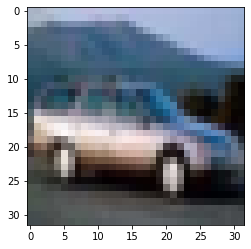

In [ ]:
digit = train_images[4]

plt.imshow(digit)#, cmap=plt.cm.binary)# color map = cm.binary는 흑백으로 찍힌다
plt.show()

작업 순서는 다음과 같습니다. 먼저 훈련 데이터 `train_images`와 `train_labels`를 네트워크에 주입합니다. 그러면 네트워크는 이미지와 레이블을 연관시킬 수 있도록 학습됩니다. 마지막으로 `test_images`에 대한 예측을 네트워크에게 요청합니다. 그리고 이 예측이 `test_labels`와 맞는지 확인할 것입니다.

신경망을 만들어 보겠습니다. 여기에서도 다음 코드를 완전히 이해하지 않아도 괜찮습니다.

In [ ]:
# STEP 1. 모델정의
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(1024, activation='relu', input_shape=((32 * 32)*3,)))
network.add(layers.Dense(512))
network.add(layers.Dense(128))
network.add(layers.Dense(64))
network.add(layers.Dense(10, activation='softmax'))# output = 10

In [ ]:
network.summary() # wx+b / wx = input + output / b = output
                  # 784 * 512 = 401,408 <-- wx의 갯수 / + b(512)의 갯수도 해줘야 숫자가 맞는다

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_26 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_27 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 10)                650       
Total params: 3,746,122
Trainable params: 3,746,122
Non-trainable params: 0
_________________________________________________________________


신경망의 핵심 구성 요소는 일종의 데이터 처리 필터라고 생각할 수 있는 층입니다. 어떤 데이터가 들어가면 더 유용한 형태로 출력됩니다. 조금 더 구체적으로 층은 주어진 문제에 더 의미 있는 표현을 입력된 데이터로부터 추출합니다. 대부분의 딥러닝은 간단한 층을 연결하여 구성되어 있고, 점진적으로 데이터를 정제하는 형태를 띠고 있습니다. 딥러닝 모델은 데이터 정제 필터(층)가 연속되어 있는 데이터 프로세싱을 위한 여과기와 같습니다.

이 예에서는 조밀하게 연결된 (또는 완전 연결된) 신경망 층인 `Dense` 층 2개가 연속되어 있습니다. 두 번째 (즉, 마지막) 층은 10개의 확률 점수가 들어 있는 배열(모두 더하면 1입니다)을 반환하는 소프트맥스 층입니다. 각 점수는 현재 숫자 이미지가 10개의 숫자 클래스 중 하나에 속할 확률입니다.

신경망이 훈련 준비를 마치기 위해서 컴파일 단계에 포함될 세 가지가 더 필요합니다:

* 손실 함수 : 훈련 데이터에서 신경망의 성능을 측정하는 방법으로 네트워크가 옳은 방향으로 학습될 수 있도록 도와 줍니다.
* 옵티마이저: 입력된 데이터와 손실 함수를 기반으로 네트워크를 업데이트하는 메커니즘입니다.
* 훈련과 테스트 과정을 모니터링할 지표 : 여기에서는 정확도(정확히 분류된 이미지의 비율)만 고려하겠습니다.

손실 함수와 옵티마이저의 정확한 목적은 이어지는 두 개의 장에서 자세히 설명하겠습니다.

In [ ]:
# STEP 2. 옵티마이저 / 손실함수 / 성능지표를 정의한다
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',# 가장 기본적인 함수
                metrics=['accuracy'])# 정확도를 기준으로

훈련을 시작하기 전에 데이터를 네트워크에 맞는 크기로 바꾸고 모든 값을 0과 1 사이로 스케일을 조정합니다. 예를 들어, 앞서 우리의 훈련 이미지는 `[0, 255]` 사이의 값인 `uint8` 타입의 `(60000, 28, 28)` 크기를 가진 배열로 저장되어 있습니다. 이 데이터를 0과 1 사이의 값을 가지는 `float32` 타입의 `(60000, 28 * 28)` 크기의 배열로 바꿉니다.

In [ ]:
# 3차원 데이터 - > 2차원 데이터
train_images = train_images.reshape((50000, (32 * 32)*3))
# 정규화 효과 모든 데이터 값을 0~1사이로 집어넣는다 = nomalize
train_images = train_images.astype('float32') / 255

In [ ]:
# 3차원 데이터 - > 2차원 데이터
test_images = test_images.reshape((10000, (32 * 32)*3))
# 정규화 효과 모든 데이터 값을 0~1사이로 집어넣는다 = nomalize
test_images = test_images.astype('float32') / 255

또한, 레이블을 범주형으로 인코딩해야 합니다. 이 단계는 3장에서 자세히 설명하겠습니다:

In [ ]:
# 원핫인코딩으로 변경해주는 함수 to_categorical
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

이제 신경망을 훈련시킬 준비가 되었습니다. 케라스에서는 `fit` 메서드를 호출하여 훈련 데이터에 모델을 학습시킵니다:

In [ ]:
network.fit(train_images, train_labels, epochs=50, batch_size=128)

Epoch 1/10
391/391 [==============================] - 26s 66ms/step - loss: 2.8550 - accuracy: 0.2267
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 1.8840 - accuracy: 0.3184
Epoch 3/10
391/391 [==============================] - 26s 67ms/step - loss: 1.7932 - accuracy: 0.3567
Epoch 4/10
391/391 [==============================] - 26s 67ms/step - loss: 1.7379 - accuracy: 0.3777
Epoch 5/10
391/391 [==============================] - 27s 68ms/step - loss: 1.6885 - accuracy: 0.3965
Epoch 6/10
391/391 [==============================] - 27s 68ms/step - loss: 1.6537 - accuracy: 0.4095
Epoch 7/10
391/391 [==============================] - 27s 68ms/step - loss: 1.6271 - accuracy: 0.4190
Epoch 8/10
391/391 [==============================] - 27s 68ms/step - loss: 1.5978 - accuracy: 0.4279
Epoch 9/10
391/391 [==============================] - 28s 71ms/step - loss: 1.5773 - accuracy: 0.4399
Epoch 10/10
391/391 [==============================] - 27s 69ms/step - loss: 1.561

In [ ]:
# 학습된 모델을 가지고 예측, 테스트
test_loss, test_acc = network.evaluate(test_images, test_labels)

313/313 [==============================] - 3s 10ms/step - loss: 1.5401 - accuracy: 0.4473


In [ ]:
print('test_acc:', test_acc)

test_acc: 0.447299987077713


In [ ]:
print('test_loss:', test_loss)

test_loss: 1.5401393175125122
